# Прогнозирование заказов такси

Сервис такси собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

По условию значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Ход работы:**

- Загрузим данные и выполним их ресемплирование по одному часу;
- Проанализируем данные;
- Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных;
- Проверим данные на тестовой выборке и сделаем выводы.

**Описание данных:**

Количество заказов находится в столбце 'num_orders'.

## Подготовка данных

In [1]:
#импортируем необходимые библиотеки и инструменты
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#с помощью аргумента parse_dates преобразуем столбец с датами в тип datetime
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
print(df.index.min())
print(df.index.max())

2018-03-01 00:00:00
2018-08-31 23:50:00


В данном датасете 26496 строк и 1 столбец. Выгрузка данных о заказах такси в аэропртах собрана с 2018-03-01 по 2018-08-31. Количество заказов (num_orders) является целевым признаком.

Информация фиксировалась с разницей в 10 минут, поэтому выполним ресемплирование с интервалом в 1 час и просуммируем:

In [6]:
df.sort_index(inplace=True)
df=df['2018-03':'2018-08'].resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные подготовлены для дальнейшего анализа.

## Анализ данных

Выведем данные на графике:

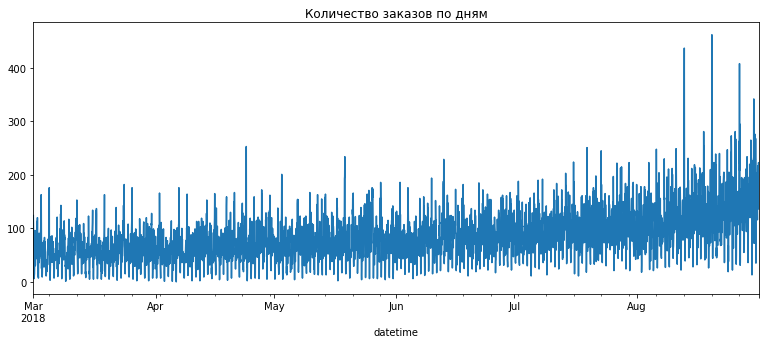

In [7]:
plt.figure(figsize=(13,5))
plt.title('Количество заказов по дням')
df['num_orders'].plot();

Видно, что временной ряд не стационарен, т.к. с изменением времени меняется его среднее значение и дисперсия.

Создадим столбец со скользящим средним и параметром window = 10:

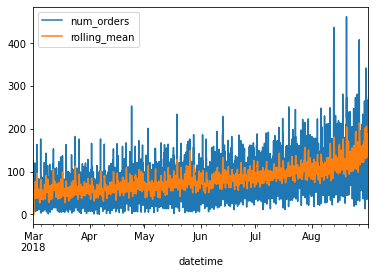

In [8]:
df['rolling_mean']=df['num_orders'].rolling(window=10).mean()
df=df.fillna(0)
df.plot();

Чтобы увидеть тренд, сезонность и белый шум, используем  функцию seasonal_decompose():

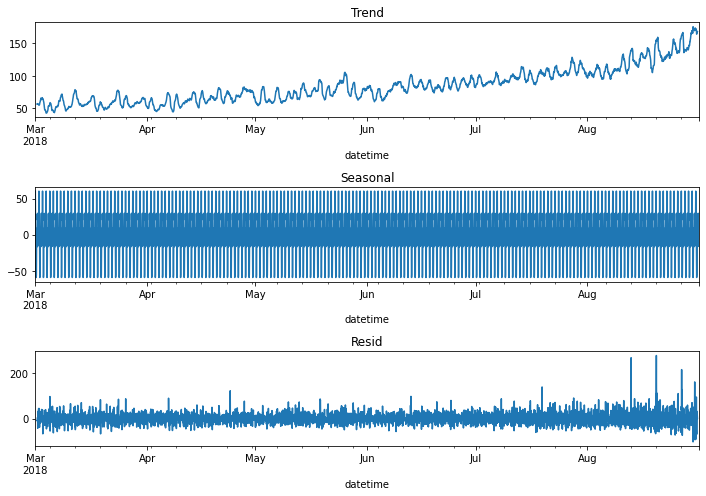

In [9]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(10, 7))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Resid')
plt.tight_layout()

По линии тренда видно, что кол-во заказов растет от мая к августу, их становится больше. О сезонности трудно судить, поэтому посмотрим на более узкий промежуток времени. Тренд за период в неделю, а сезонность в период день:

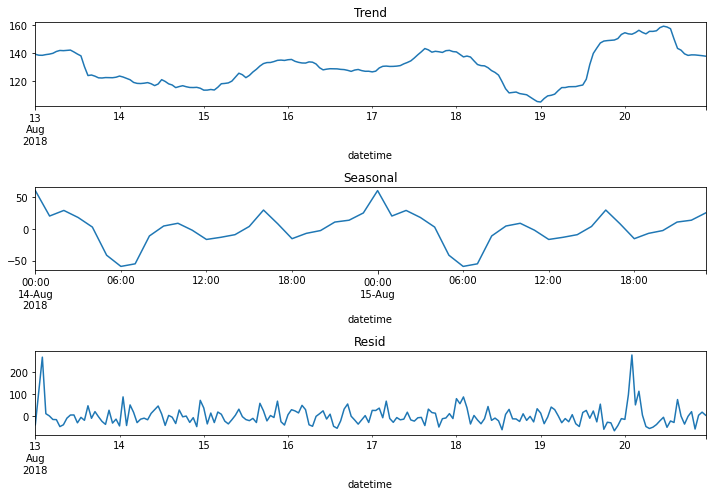

In [10]:
plt.figure(figsize=(10, 7))
plt.subplot(311)

decomposed.trend['2018-08-13':'2018-08-20'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)

decomposed.seasonal['2018-08-14':'2018-08-15'].plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)

decomposed.resid['2018-08-13':'2018-08-20'].plot(ax=plt.gca())
plt.title('Resid')
plt.tight_layout()

Таким образом мы увидели всплески заказов в определенные дни недели, в воскресенье виден явный спад по заказам. А также оценили почасовую нагрузку в течение дня. Виден сильный спад по кол-ву заказов в 6 утра и подъем к 00:00 часам.

Попробуем преобразовать временной ряд в стационарный с помощью метода shift:

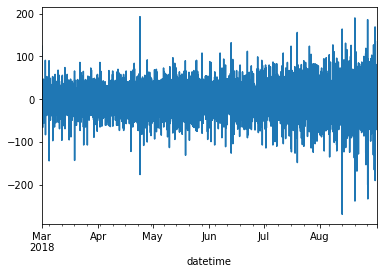

In [11]:
df_shift = df - df.shift(fill_value=0)
df_shift.num_orders.plot();

Временной ряд поддался изменениям и стал более стационарным, значит данные можно прогнозировать. Теперь можно переходить к обучению моделей.

## Обучение моделей

Для обучения модели необходимо добавить дополнительные признаки. Для этого нам понадобится функция make_features():

In [12]:
def make_features(df, max_lag, rolling_mean_size):
  
    #df['Year']=df.index.year #добавляем 4 новых календарных признака: год, месяц, день и день недели
    #df['Month']=df.index.month
   # df['Day']=df.index.day
    df['Day_of_week']=df.index.dayofweek
    df['Hour']=df.index.hour
    
    for i in range(1,max_lag+1): #вычисляет и добавляет отстающие значения
        df['lag_{}'.format(i)]=df['num_orders'].shift(i)
        
    #вычисляет скользящее среднее и добавляет его как признак rolling_mean    
    df['rolling_mean']=df['num_orders'].shift().rolling(window=rolling_mean_size).mean()
    
    return df

In [13]:
taxi = make_features(df, 3, 3)#проверка функции
taxi.head()

,num_orders,rolling_mean,Day_of_week,Hour,lag_1,lag_2,lag_3
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,93.333333,3,3,71.0,85.0,124.0
2018-03-01 04:00:00,43,74.000000,3,4,66.0,71.0,85.0


### LinearRegression

In [14]:
df_maked = make_features(df,2,24)

In [15]:
#Разделим данные на обучающую, тестовую выборки и подготовим признаки:
df_maked = df_maked.dropna()
target = df_maked['num_orders']
features = df_maked.drop(['num_orders'],axis=1)

features_train, features_test, target_train, target_test = train_test_split(features,target,test_size=0.1,shuffle=False)

In [16]:
#напишем формулу для получения значения метрики RMSE
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

In [17]:
model_lr = LinearRegression()

In [18]:
%%time
model_lr.fit(features_train, target_train)
predicted_lr = pd.Series(model_lr.predict(features_test))
rmse(target_test, predicted_lr)

Wall time: 12 ms


50.59221683043384

In [19]:
def make_plt(test, predictions):
    data = pd.DataFrame(test).reset_index()
    data['predicted']= predictions.astype('int')
    data_plt = data[:49]
    plt.figure(figsize=(15,7))
    plt.plot(data_plt['datetime'], data_plt['num_orders'], label ="Реальные")
    plt.plot(data_plt['datetime'], data_plt['predicted'], label ="Предсказанные")
    plt.xlabel('Дата и время')
    plt.ylabel('Число заказов')
    plt.grid(which='major')
    plt.title('Результаты модели, 2 дня')
    plt.legend()
    plt.show()

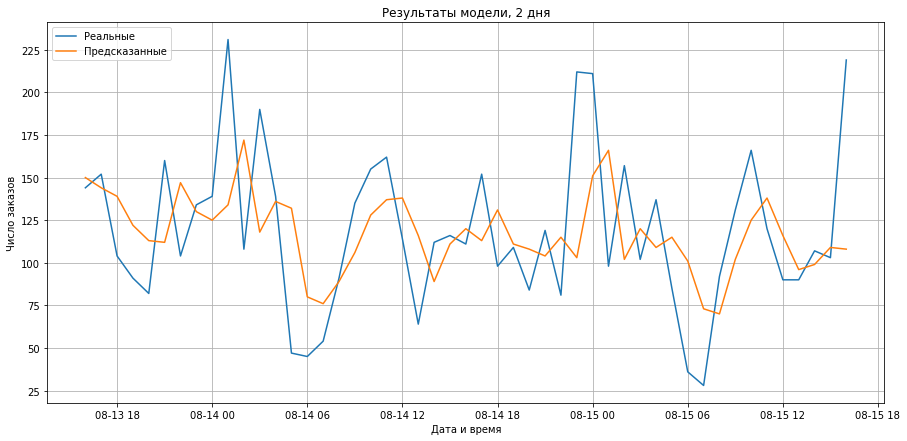

In [20]:
make_plt(target_test, predicted_lr)

### CatBoostRegressor

Построим модель CBR и исследуем её работу с различными значениями гиперпараметра iterations с помощью кросс-валидации:

In [21]:
model_cat = CatBoostRegressor()

param_set = {
    'learning_rate':[x/10 for x in range(1, 6)],
    'random_state':[24072020],
    'n_estimators': [110,150,200],
    'max_depth': [1,5,10]
}
    
tscv = TimeSeriesSplit(n_splits=8)
gbm = GridSearchCV(model_cat, param_grid=param_set, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
gbm.fit(features_train, target_train)
print('Best parameters:', gbm.best_params_)

Fitting 8 folds for each of 45 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.8min finished


0:	learn: 37.0794621	total: 145ms	remaining: 28.8s
1:	learn: 35.4990645	total: 149ms	remaining: 14.8s
2:	learn: 34.0159927	total: 153ms	remaining: 10.1s
3:	learn: 33.2019369	total: 157ms	remaining: 7.69s
4:	learn: 32.1908347	total: 161ms	remaining: 6.28s
5:	learn: 31.1274868	total: 166ms	remaining: 5.36s
6:	learn: 30.5076545	total: 169ms	remaining: 4.67s
7:	learn: 29.7065241	total: 173ms	remaining: 4.16s
8:	learn: 29.2192839	total: 176ms	remaining: 3.73s
9:	learn: 28.7527260	total: 179ms	remaining: 3.39s
10:	learn: 28.3107039	total: 182ms	remaining: 3.12s
11:	learn: 27.8646935	total: 185ms	remaining: 2.89s
12:	learn: 27.5733012	total: 187ms	remaining: 2.69s
13:	learn: 27.1939642	total: 190ms	remaining: 2.52s
14:	learn: 26.9012848	total: 192ms	remaining: 2.37s
15:	learn: 26.5745438	total: 194ms	remaining: 2.23s
16:	learn: 26.3789140	total: 196ms	remaining: 2.11s
17:	learn: 26.1621115	total: 197ms	remaining: 2s
18:	learn: 26.0048330	total: 199ms	remaining: 1.9s
19:	learn: 25.7732372	tota

Попробуем разные значения глубины для модели:

In [ ]:
#for depth in range(1, 10, 2):
    #model_cat = CatBoostRegressor(loss_function="RMSE", iterations=150, depth=depth, verbose=10)
    #cat_cv = cross_val_score(model_cat, features_train, target_train, cv=2)
    #print("Score для depth =", depth, ":", cat_cv)
    #print("Score mean =", sum(cat_cv)/len(cat_cv))
    #print()

Для обучения модели CBR используем гиперпараметры: iterations = 110 и depth = 5. На мой взгляд, они показали лучший результат по качеству и времени во время подбора.

In [24]:
%%time
model_cat_best= CatBoostRegressor(loss_function="RMSE", iterations=110, depth=5, verbose=10)
model_cat_best.fit(features_train, target_train)
predicted_cat_best = pd.DataFrame(model_cat_best.predict(features_test))

Learning rate set to 0.306073
0:	learn: 33.9969584	total: 3.59ms	remaining: 391ms
10:	learn: 24.3206051	total: 30.6ms	remaining: 276ms
20:	learn: 22.8538216	total: 52.8ms	remaining: 224ms
30:	learn: 21.6905732	total: 71.9ms	remaining: 183ms
40:	learn: 20.7834626	total: 90.2ms	remaining: 152ms
50:	learn: 19.9839025	total: 108ms	remaining: 125ms
60:	learn: 19.6200662	total: 125ms	remaining: 100ms
70:	learn: 19.2141038	total: 141ms	remaining: 77.6ms
80:	learn: 18.7319274	total: 158ms	remaining: 56.6ms
90:	learn: 18.3661720	total: 177ms	remaining: 37ms
100:	learn: 18.0483449	total: 194ms	remaining: 17.3ms
109:	learn: 17.7475069	total: 210ms	remaining: 0us
Wall time: 288 ms


In [25]:
rmse(target_test, predicted_cat_best)

44.67574527725654

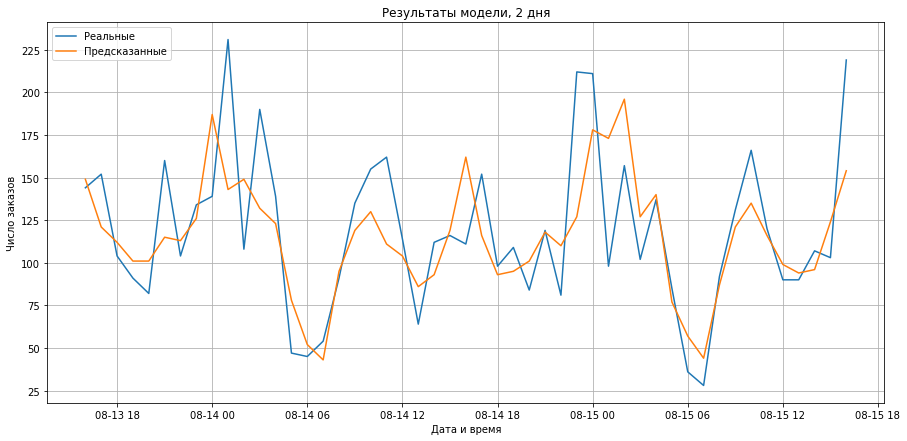

In [26]:
make_plt(target_test, predicted_cat_best)

### LightGBM

In [27]:
model_test = lgb.LGBMRegressor(num_leaves= 31,learning_rate=0.01)

param_grid = {
    'n_estimators': [500,600,700],
    'max_depth': [1,5,10,15,20]
   
}

cv =KFold(random_state=1, n_splits=7, shuffle=False)
gbm = GridSearchCV(model_test, param_grid, cv=cv, scoring='neg_mean_squared_error')

gbm.fit(features_train, target_train)

print('Best parameters:', gbm.best_params_)
print('Best score:', gbm.best_score_)

Best parameters: {'max_depth': 20, 'n_estimators': 700}
Best score: -535.646814235184


In [32]:
%%time
model_lgbm = lgb.LGBMRegressor(num_leaves= 31, learning_rate=0.01, max_depth=20, n_estimators=700)
model_lgbm.fit(features_train, target_train)
predictions_lgbm =  pd.DataFrame(model_lgbm.predict(features_test))

Wall time: 638 ms


In [34]:
rmse(target_test, predictions_lgbm)

44.0871019616059

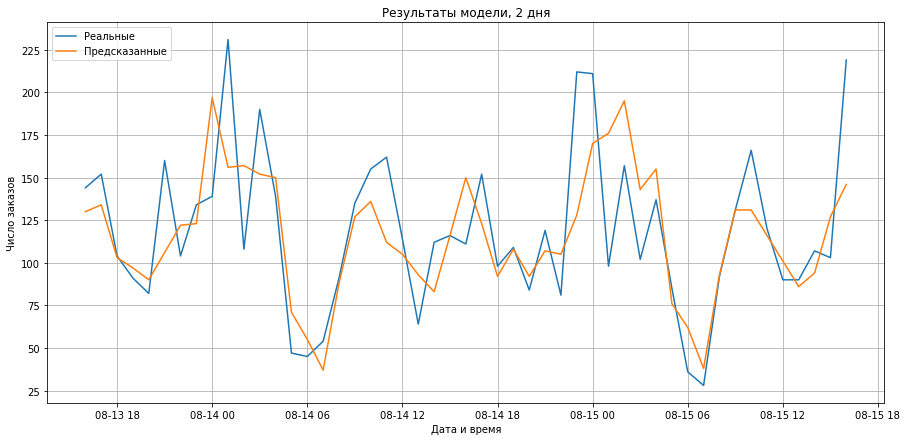

In [35]:
make_plt(target_test, predictions_lgbm)

## Анализ моделей

Создадим сравнительную таблицу:

In [36]:
models = [['LR', 50.59], ['CBR', 44.67], 
       ['LGB', 44.08]] 
    
data = pd.DataFrame(models, columns =['model', 'rmse']) 
data 

,model,rmse
0,LR,50.59
1,CBR,44.67
2,LGB,44.08


### ВЫВОД

Все три модели показали себя хорошо, метрика rmse не превысила 48. Худший результат оказался у модели линейно регрессии. CBR и LGB показали примерно одинаковые результаты с настройками на лучшие гиперпараметры. По времени обучения модели, CBR быстрее, LGB немного дольше обучается. 

Скорость обучения модели в данной задаче также важна. У нас были данные всего за полгода, если бы у компании имелись данные за несколько лет, то модели обучались бы гораздо дольше. Поэтому для прогнозирования заказов такси, я выбрала CatBoostRegressor с параметрами iterations=110 и depth=5. 